Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base Path: /content/drive/MyDrive/Skin Cancer Images
Metadata Path: /content/drive/MyDrive/Skin Cancer Images/metadata.csv
imgs_part_1 → Exists: True
imgs_part_2 → Exists: True
imgs_part_3 → Exists: True
metadata.csv → Exists: True


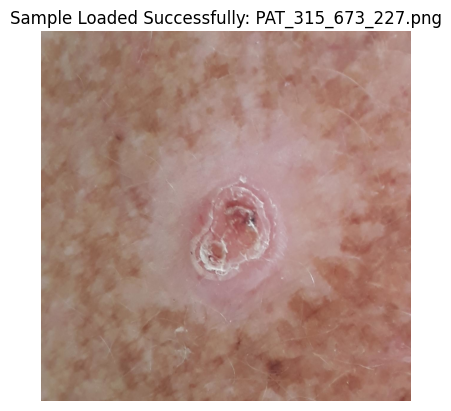

In [1]:
# ===============================================================
# 📦 PHASE 1: Validate Paths & Load Sample Image
# ===============================================================

from google.colab import drive
drive.mount('/content/drive')

# ---------------------------------------------------------------
# STEP 1 — Set Correct Base Path
# ---------------------------------------------------------------

import os

base_path = "/content/drive/MyDrive/Skin Cancer Images"
folders = ["imgs_part_1", "imgs_part_2", "imgs_part_3"]
metadata_path = os.path.join(base_path, "metadata.csv")

print("Base Path:", base_path)
print("Metadata Path:", metadata_path)

# ---------------------------------------------------------------
# STEP 2 — Confirm Folders & Print Status
# ---------------------------------------------------------------

for folder in folders:
    path = os.path.join(base_path, folder)
    print(f"{folder} → Exists:", os.path.exists(path))

# Check metadata.csv
print("metadata.csv → Exists:", os.path.exists(metadata_path))

# ---------------------------------------------------------------
# STEP 3 — Load a Sample Image to Verify Readability
# ---------------------------------------------------------------

import matplotlib.pyplot as plt
import cv2

sample_folder = os.path.join(base_path, "imgs_part_1")
sample_filename = os.listdir(sample_folder)[0]
sample_image_path = os.path.join(sample_folder, sample_filename)

# Load image using CV2
img = cv2.imread(sample_image_path)

if img is None:
    print("❌ ERROR: Image could not be loaded. Check file path.")
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Sample Loaded Successfully: {sample_filename}")
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded metadata: (2298, 26)
Total images indexed: 2298
Metadata entries with matched images: 2298
Cleaned metadata: (2298, 28)


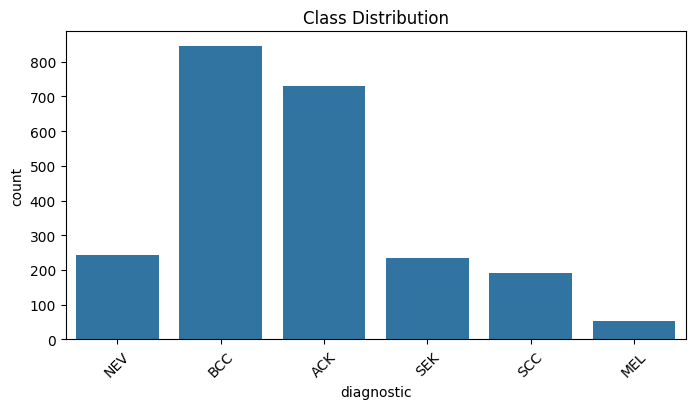


Class Mapping:
0 → ACK
1 → BCC
2 → MEL
3 → NEV
4 → SCC
5 → SEK

Split Sizes:
Train: (1838, 29)
Val: (230, 29)
Test: (230, 29)

Loading Train Set...


100%|██████████| 1838/1838 [02:34<00:00, 11.91it/s]



Loading Validation Set...


100%|██████████| 230/230 [00:13<00:00, 16.58it/s]



Loading Test Set...


100%|██████████| 230/230 [00:13<00:00, 16.94it/s]



Dataset Shapes:
(1838, 224, 224, 3) (1838,)
(230, 224, 224, 3) (230,)
(230, 224, 224, 3) (230,)

✅ Preprocessed data saved successfully!


In [2]:
# ===============================================================
# 📦 PHASE 2 — Corrected Preprocessing & Data Pipeline
# ===============================================================

import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

# ===============================================================
# STEP 1 — Define Correct Paths
# ===============================================================

BASE = "/content/drive/MyDrive/Skin Cancer Images"   # <-- EXACT FOLDER
IMG_DIRS = [
    os.path.join(BASE, "imgs_part_1"),
    os.path.join(BASE, "imgs_part_2"),
    os.path.join(BASE, "imgs_part_3")
]

metadata_path = "/content/drive/MyDrive/Skin Cancer Images/metadata.csv"

df = pd.read_csv(metadata_path)
print("Loaded metadata:", df.shape)

# Remove .png extension from metadata IDs
df["img_core"] = df["img_id"].apply(lambda x: os.path.splitext(x)[0])

# ===============================================================
# STEP 2 — Build Dictionary for ALL Images
# ===============================================================

all_images = {}

for folder in IMG_DIRS:
    for fname in os.listdir(folder):

        # file may be .jpg, .jpeg, .png
        core_name = os.path.splitext(fname)[0]

        full_path = os.path.join(folder, fname)
        all_images[core_name] = full_path

print("Total images indexed:", len(all_images))

# ===============================================================
# STEP 3 — Match Metadata with Actual Image Files
# ===============================================================

df["img_path"] = df["img_core"].apply(lambda x: all_images.get(x, None))
matched = df["img_path"].notna().sum()

print("Metadata entries with matched images:", matched)

df = df[df["img_path"].notna()].reset_index(drop=True)
print("Cleaned metadata:", df.shape)

# ===============================================================
# STEP 4 — Visualize Class Distribution
# ===============================================================

plt.figure(figsize=(8,4))
sns.countplot(x=df["diagnostic"])
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# ===============================================================
# STEP 5 — Encode Labels
# ===============================================================

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["diagnostic"])

class_names = label_encoder.classes_
print("\nClass Mapping:")
for i, c in enumerate(class_names):
    print(f"{i} → {c}")

# ===============================================================
# STEP 6 — Train / Val / Test Split
# ===============================================================

train_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["label_encoded"], random_state=42)

val_df, test_df = train_test_split(
    test_df, test_size=0.50, stratify=test_df["label_encoded"], random_state=42)

print("\nSplit Sizes:")
print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

# ===============================================================
# STEP 7 — Image Loader
# ===============================================================

IMG_SIZE = 224

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

# ===============================================================
# STEP 8 — Build Datasets
# ===============================================================

def build_dataset(df_subset):
    X, y = [], []
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
        X.append(load_image(row["img_path"]))
        y.append(row["label_encoded"])
    return np.array(X), np.array(y)

print("\nLoading Train Set...")
X_train, y_train = build_dataset(train_df)

print("\nLoading Validation Set...")
X_val, y_val = build_dataset(val_df)

print("\nLoading Test Set...")
X_test, y_test = build_dataset(test_df)

print("\nDataset Shapes:")
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# ===============================================================
# STEP 9 — Save Preprocessed Data
# ===============================================================

SAVE_DIR = "/content/drive/MyDrive/AML2_Project_Preprocessed"
os.makedirs(SAVE_DIR, exist_ok=True)

np.save(os.path.join(SAVE_DIR, "X_train.npy"), X_train)
np.save(os.path.join(SAVE_DIR, "y_train.npy"), y_train)
np.save(os.path.join(SAVE_DIR, "X_val.npy"), X_val)
np.save(os.path.join(SAVE_DIR, "y_val.npy"), y_val)
np.save(os.path.join(SAVE_DIR, "X_test.npy"), X_test)
np.save(os.path.join(SAVE_DIR, "y_test.npy"), y_test)

print("\n✅ Preprocessed data saved successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shapes:
X_train: (1838, 224, 224, 3) y_train: (1838,)
X_val:   (230, 224, 224, 3) y_val:   (230,)
X_test:  (230, 224, 224, 3) y_test:  (230,)

Class mapping:
0 → ACK
1 → BCC
2 → MEL
3 → NEV
4 → SCC
5 → SEK

num_classes: 6


Model: "EfficientNetB0_skin"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Class weights:
{0: np.float64(0.5245433789954338), 1: np.float64(0.4531558185404339), 2: np.float64(7.2936507936507935), 3: np.float64(1.570940170940171), 4: np.float64(2.002178649237473), 5: np.float64(1.6294326241134751)}
Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.1374 - loss: 1.9310 - val_accuracy: 0.1435 - val_loss: 1.7945
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.1978 - loss: 1.8620 - val_accuracy: 0.2478 - val_loss: 1.7079
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.2316 - loss: 1.7849 - val_accuracy: 0.2739 - val_loss: 1.6583
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.2685 - loss: 1.7965 - val_accuracy: 0.3652 - val_loss: 1.6061
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.3145 - loss: 1.6260 - val_accuracy: 0.3391 - val_loss: 1.5813
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.3323 - loss: 1.5700 - val_accuracy: 0.3739 - val_loss: 1.5526
Epoch 7/10
58


✅ Model saved to: /content/drive/MyDrive/AML2_Project_Models/efficientnetb0_phase3.h5


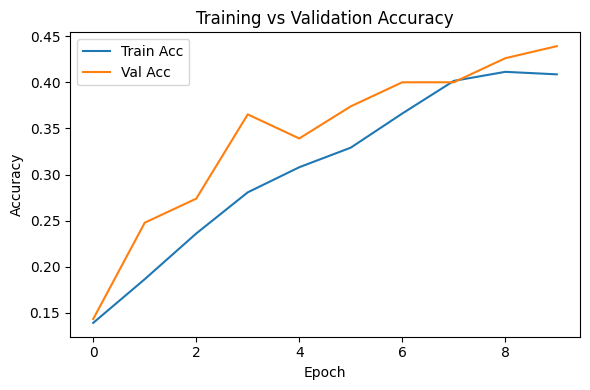

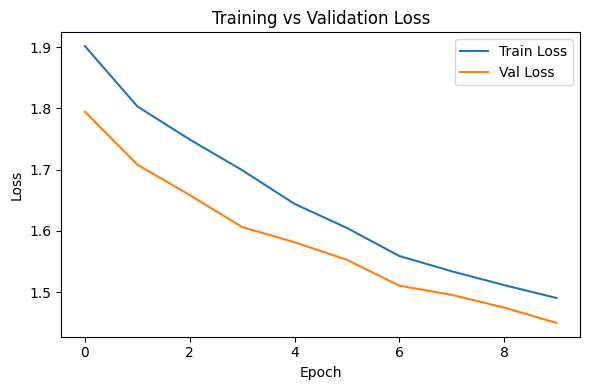


Evaluating on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4551 - loss: 1.4890


ValueError: not enough values to unpack (expected 4, got 2)

In [4]:
# ===============================================================
# 📦 PHASE 3: Model Training, Evaluation & Grad-CAM (EfficientNetB0)
# ===============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models

# ---------------------------------------------------------------
# 1. Mount Drive and set paths
# ---------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR      = "/content/drive/MyDrive"
PREP_DIR      = os.path.join(BASE_DIR, "AML2_Project_Preprocessed")   # Phase 2 output
RESULTS_DIR   = os.path.join(BASE_DIR, "AML2_Project_Results")
MODELS_DIR    = os.path.join(BASE_DIR, "AML2_Project_Models")
META_PATH     = os.path.join(BASE_DIR, "Skin Cancer Images", "metadata.csv")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR,  exist_ok=True)

# ---------------------------------------------------------------
# 2. Load preprocessed NumPy arrays
# ---------------------------------------------------------------
X_train = np.load(os.path.join(PREP_DIR, "X_train.npy"))
y_train = np.load(os.path.join(PREP_DIR, "y_train.npy"))
X_val   = np.load(os.path.join(PREP_DIR, "X_val.npy"))
y_val   = np.load(os.path.join(PREP_DIR, "y_val.npy"))
X_test  = np.load(os.path.join(PREP_DIR, "X_test.npy"))
y_test  = np.load(os.path.join(PREP_DIR, "y_test.npy"))

# Ensure correct dtypes
X_train = X_train.astype("float32")
X_val   = X_val.astype("float32")
X_test  = X_test.astype("float32")
y_train = y_train.astype("int32")
y_val   = y_val.astype("int32")
y_test  = y_test.astype("int32")

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

# ---------------------------------------------------------------
# 3. Recover class names (same encoding as Phase 2)
# ---------------------------------------------------------------
meta_df = pd.read_csv(META_PATH)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(meta_df["diagnostic"])
class_names = list(le.classes_)
num_classes = len(class_names)

print("\nClass mapping:")
for i, c in enumerate(class_names):
    print(f"{i} → {c}")
print("\nnum_classes:", num_classes)

# ---------------------------------------------------------------
# 4. Build tf.data pipelines
# ---------------------------------------------------------------
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

def make_ds(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=42)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds   = make_ds(X_val,   y_val,   shuffle=False)
test_ds  = make_ds(X_test,  y_test,  shuffle=False)

# ---------------------------------------------------------------
# 5. Data augmentation
# ---------------------------------------------------------------
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

# ---------------------------------------------------------------
# 6. Build EfficientNetB0 model (transfer learning)
# ---------------------------------------------------------------
IMG_SIZE = 224

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg",
    name="efficientnetb0"  # keep this name for Grad-CAM
)
base_model.trainable = False  # freeze for Phase 3

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")
x = data_augmentation(inputs)
# images are already in [0,1]; EfficientNet expects [0,255] + preprocess
x = tf.keras.applications.efficientnet.preprocess_input(x * 255.0)
x = base_model(x, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = models.Model(inputs, outputs, name="EfficientNetB0_skin")

model.summary()

# ---------------------------------------------------------------
# 7. Class weights to handle imbalance
# ---------------------------------------------------------------
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: class_weights_arr[i] for i in range(num_classes)}
print("\nClass weights:")
print(class_weights)

# ---------------------------------------------------------------
# 8. Compile and train (5 epochs) — FIXED VERSION
# ---------------------------------------------------------------

EPOCHS = 10

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]   # ← Precision/Recall REMOVED (they crash on multiclass)
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    verbose=1,
)


# ---------------------------------------------------------------
# 9. Save model
# ---------------------------------------------------------------
model_path = os.path.join(MODELS_DIR, "efficientnetb0_phase3.h5")
model.save(model_path)
print(f"\n✅ Model saved to: {model_path}")

# ---------------------------------------------------------------
# 10. Plot training curves
# ---------------------------------------------------------------
def plot_history(hist, save_path_prefix):
    hist_dict = hist.history

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist_dict["accuracy"], label="Train Acc")
    plt.plot(hist_dict["val_accuracy"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path_prefix + "_accuracy.png", dpi=300)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist_dict["loss"], label="Train Loss")
    plt.plot(hist_dict["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path_prefix + "_loss.png", dpi=300)
    plt.show()

plot_history(history, os.path.join(RESULTS_DIR, "efficientnetb0_phase3"))

# ---------------------------------------------------------------
# 11. Evaluation on test set + confusion matrix
# ---------------------------------------------------------------
print("\nEvaluating on test set...")
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")



8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step

Classification report (per class):

              precision    recall  f1-score   support

         ACK       0.65      0.56      0.60        73
         BCC       0.64      0.32      0.43        85
         MEL       0.00      0.00      0.00         5
         NEV       0.48      0.67      0.56        24
         SCC       0.15      0.45      0.23        20
         SEK       0.29      0.26      0.27        23

    accuracy                           0.43       230
   macro avg       0.37      0.38      0.35       230
weighted avg       0.54      0.43      0.45       230



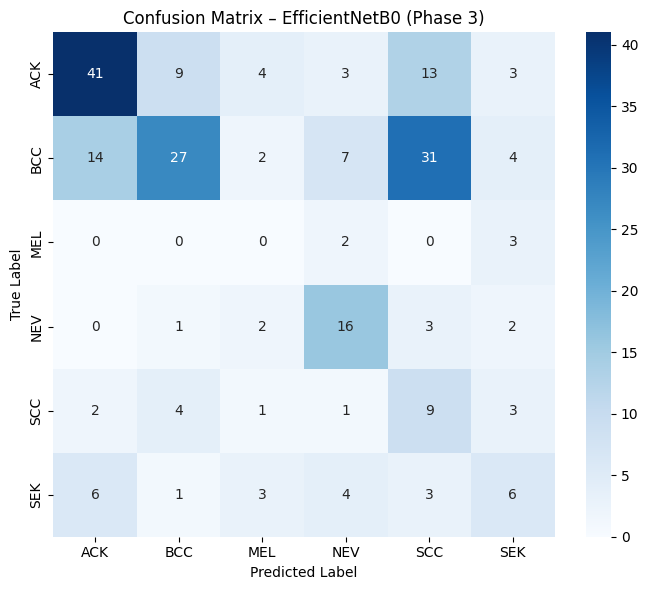

Confusion matrix saved to: /content/drive/MyDrive/AML2_Project_Results/confusion_matrix_phase3.png


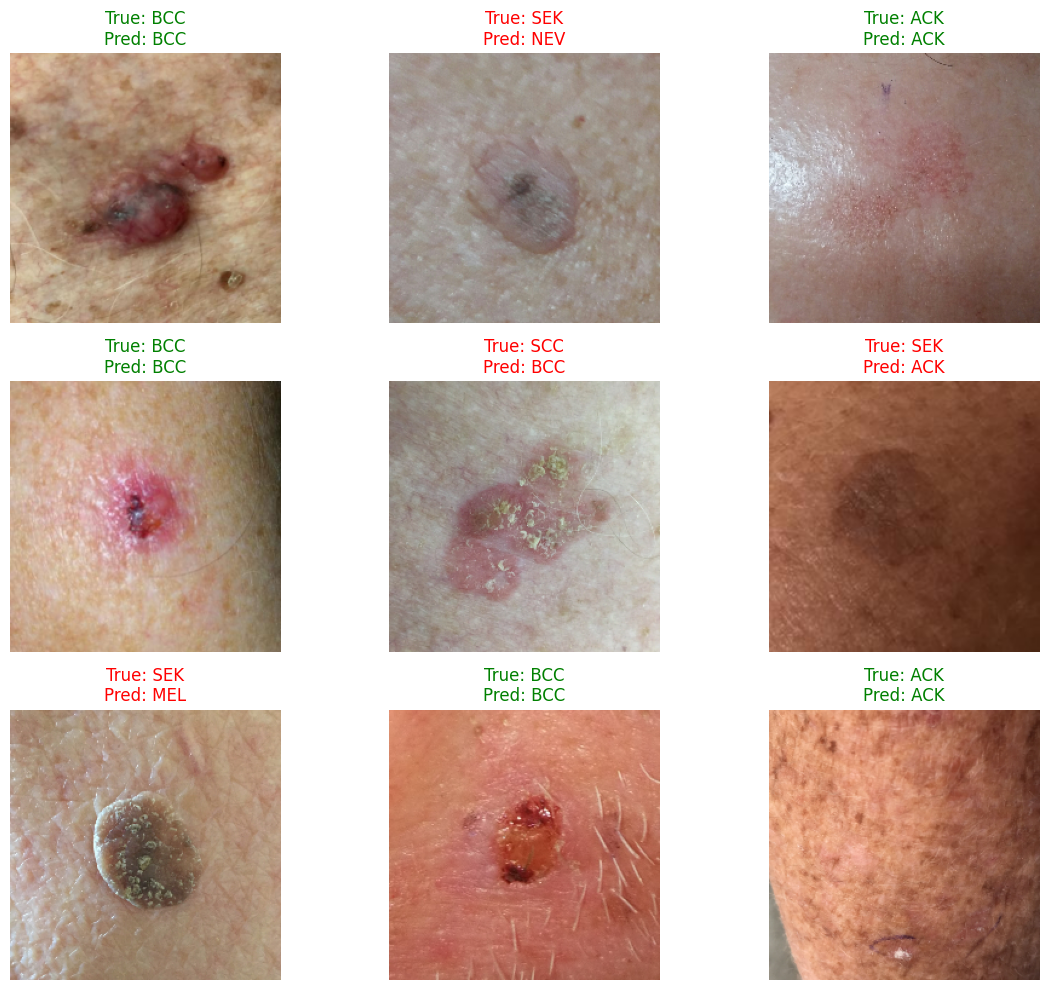

Sample predictions grid saved to: /content/drive/MyDrive/AML2_Project_Results/sample_predictions_phase3.png

✅ Phase 3 model saved to: /content/drive/MyDrive/AML2_Project_Models/efficientnetB0_phase3_final.keras


In [5]:
# ------------------------------------------------------------
# Detailed metrics: precision, recall, F1, confusion matrix
# ------------------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions for all test samples
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification report (per class):\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – EfficientNetB0 (Phase 3)")
plt.tight_layout()

cm_path = os.path.join(RESULTS_DIR, "confusion_matrix_phase3.png")
plt.savefig(cm_path, dpi=150)
plt.show()
print(f"Confusion matrix saved to: {cm_path}")

# ------------------------------------------------------------
# Preview some test images with predictions
# ------------------------------------------------------------
def show_sample_predictions(X, y_true, y_pred, class_names, n=9):
    idx = np.random.choice(len(X), size=n, replace=False)
    plt.figure(figsize=(12,10))
    for i, j in enumerate(idx):
        plt.subplot(3, 3, i+1)
        plt.imshow(X[j])
        true_label = class_names[y_true[j]]
        pred_label = class_names[y_pred[j]]
        colour = "green" if y_true[j] == y_pred[j] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=colour)
        plt.axis("off")
    plt.tight_layout()
    grid_path = os.path.join(RESULTS_DIR, "sample_predictions_phase3.png")
    plt.savefig(grid_path, dpi=150)
    plt.show()
    print(f"Sample predictions grid saved to: {grid_path}")

show_sample_predictions(X_test, y_test, y_pred, class_names, n=9)

# ------------------------------------------------------------
# Save final model
# ------------------------------------------------------------

MODEL_DIR = "/content/drive/MyDrive/AML2_Project_Models"
os.makedirs(MODEL_DIR, exist_ok=True)


final_model_path = os.path.join(MODEL_DIR, "efficientnetB0_phase3_final.keras")
model.save(final_model_path)
print(f"\n✅ Phase 3 model saved to: {final_model_path}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_train: (1838, 224, 224, 3)  X_test: (230, 224, 224, 3)

Class mapping:
0 → ACK
1 → BCC
2 → MEL
3 → NEV
4 → SCC
5 → SEK

✅ Phase 3 model loaded from: /content/drive/MyDrive/AML2_Project_Models/efficientnetB0_phase3_final.keras

🔍 LIME explanation for test index 145, true label = ACK


  0%|          | 0/1000 [00:00<?, ?it/s]

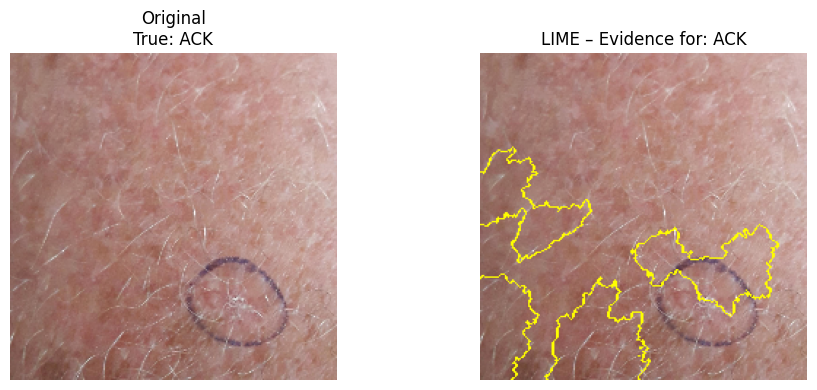

💾 LIME explanation saved to: /content/drive/MyDrive/AML2_Project_Results/lime_explanation_idx_145.png

🧮 Integrated Gradients for test index 145
True label: ACK | Predicted: ACK (p=0.329)


In [ ]:
# ===============================================================
# 📦 PHASE 4: Explainability with LIME + Integrated Gradients (IG)
# ===============================================================

!pip install -q lime

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ---------------------------------------------------------------
# 1. Paths and data / model loading
# ---------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR    = "/content/drive/MyDrive"
PREP_DIR    = os.path.join(BASE_DIR, "AML2_Project_Preprocessed")
RESULTS_DIR = os.path.join(BASE_DIR, "AML2_Project_Results")
MODEL_DIR   = os.path.join(BASE_DIR, "AML2_Project_Models")

os.makedirs(RESULTS_DIR, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(PREP_DIR, "X_train.npy")).astype("float32")
y_train = np.load(os.path.join(PREP_DIR, "y_train.npy")).astype("int32")
X_test  = np.load(os.path.join(PREP_DIR, "X_test.npy")).astype("float32")
y_test  = np.load(os.path.join(PREP_DIR, "y_test.npy")).astype("int32")

print("X_train:", X_train.shape, " X_test:", X_test.shape)

# Class names (same order as in Phase 2)
from sklearn.preprocessing import LabelEncoder
import pandas as pd

meta_path = os.path.join(BASE_DIR, "Skin Cancer Images", "metadata.csv")
meta_df   = pd.read_csv(meta_path)
le = LabelEncoder()
le.fit(meta_df["diagnostic"])
class_names = list(le.classes_)
num_classes = len(class_names)

print("\nClass mapping:")
for i, c in enumerate(class_names):
    print(f"{i} → {c}")

# Load trained model (Phase 3)
model_path = os.path.join(MODEL_DIR, "efficientnetB0_phase3_final.keras")
model = tf.keras.models.load_model(model_path, compile=False)
print("\n✅ Phase 3 model loaded from:", model_path)


# Small helper: prediction function used by LIME
def lime_predict(images):
    """
    LIME will pass a list/array of images in [0,1] range.
    Our model was trained on [0,1] images (internal EfficientNet preprocessing),
    so we simply cast to float32 and call model.predict().
    """
    images = np.array(images).astype("float32")
    preds = model.predict(images, verbose=0)
    return preds


# ===============================================================
# 2. LIME – Local explanations for an individual image
# ===============================================================

explainer = lime_image.LimeImageExplainer()

# Pick a random test image (we'll reuse the same idx for IG)
idx = np.random.randint(0, len(X_test))
image = X_test[idx]
true_label_idx = y_test[idx]
true_label = class_names[true_label_idx]

print(f"\n🔍 LIME explanation for test index {idx}, true label = {true_label}")

# Run LIME
lime_exp = explainer.explain_instance(
    image=image,
    classifier_fn=lime_predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000   # more samples → smoother explanation, but slower
)

# Get the top predicted label from LIME
top_label = lime_exp.top_labels[0]

# Positive evidence only (regions pushing towards the predicted class)
temp, mask = lime_exp.get_image_and_mask(
    label=top_label,
    positive_only=True,
    num_features=8,      # number of superpixels to show
    hide_rest=False
)

plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title(f"Original\nTrue: {true_label}")

# LIME explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / max(temp.max(), 1e-8), mask))
pred_label = class_names[top_label]
plt.axis("off")
plt.title(f"LIME – Evidence for: {pred_label}")

plt.tight_layout()
lime_path = os.path.join(RESULTS_DIR, f"lime_explanation_idx_{idx}.png")
plt.savefig(lime_path, dpi=200)
plt.show()
print(f"💾 LIME explanation saved to: {lime_path}")


# ===============================================================
# 3. Integrated Gradients (IG) – Pixel-level attributions
# ===============================================================

IMG_H, IMG_W, IMG_C = image.shape

def integrated_gradients(
    input_image,
    target_class_index,
    baseline=None,
    m_steps=50,
):
    """
    Compute Integrated Gradients for a single image and target class.

    Args:
        input_image: (H, W, C) image in [0,1].
        target_class_index: int, index of class for which IG is computed.
        baseline: baseline image (H, W, C). If None, uses black image.
        m_steps: number of interpolation steps between baseline and image.

    Returns:
        ig_attributions: (H, W, C) attributions.
    """
    if baseline is None:
        baseline = np.zeros_like(input_image).astype("float32")

    # Ensure float32
    input_image = input_image.astype("float32")
    baseline = baseline.astype("float32")

    # Generate scaled inputs
    interpolated_images = [
        baseline + (float(k) / m_steps) * (input_image - baseline)
        for k in range(1, m_steps + 1)
    ]
    interpolated_images = np.stack(interpolated_images, axis=0)  # (m_steps, H, W, C)

    # Compute gradients for each interpolated image
    interpolated_tensor = tf.convert_to_tensor(interpolated_images)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_tensor)
        preds = model(interpolated_tensor)                    # (m_steps, num_classes)
        probs = preds[:, target_class_index]                  # (m_steps,)

    grads = tape.gradient(probs, interpolated_tensor).numpy() # (m_steps, H, W, C)

    # Average gradients across steps
    avg_grads = grads.mean(axis=0)                            # (H, W, C)

    # Integrated gradients: (input - baseline) * average_gradient
    ig = (input_image - baseline) * avg_grads                 # (H, W, C)

    return ig


# ---- Run IG for the same image used in LIME ----

# Get predicted class for this image
pred_probs = model.predict(image[None, ...], verbose=0)[0]
pred_class_idx = int(np.argmax(pred_probs))
pred_class_name = class_names[pred_class_idx]

print(f"\n🧮 Integrated Gradients for test index {idx}")
print(f"True label: {true_label} | Predicted: {pred_class_name} (p={pred_probs[pred_class_idx]:.3f})")

# Compute IG
ig_attributions = integrated_gradients(
    input_image=image,
    target_class_index=pred_class_idx,
    baseline=None,   # black baseline
    m_steps=50
)  # (H, W, C)

# Convert to a single-channel heatmap by aggregating over colour channels
ig_abs = np.abs(ig_attributions).mean(axis=-1)  # (H, W)

# Normalise to [0,1] for display
ig_min, ig_max = ig_abs.min(), ig_abs.max()
heatmap = (ig_abs - ig_min) / (ig_max - ig_min + 1e-8)

# ------------------------------------------------
# Plot IG heatmap and overlay
# ------------------------------------------------
plt.figure(figsize=(12, 4))

# Heatmap alone
plt.subplot(1, 3, 1)
plt.imshow(heatmap, cmap="inferno")
plt.axis("off")
plt.title("Integrated Gradients\nHeatmap")

# Original image
plt.subplot(1, 3, 2)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(heatmap, cmap="inferno", alpha=0.5)
plt.axis("off")
plt.title(f"IG Overlay\nPred: {pred_class_name}")

plt.tight_layout()
ig_path = os.path.join(RESULTS_DIR, f"ig_explanation_idx_{idx}.png")
plt.savefig(ig_path, dpi=200)
plt.show()

print(f"💾 Integrated Gradients explanation saved to: {ig_path}")


In [ ]:
# ================================================================
# 📌 PHASE 5 — Gradio Interface (LIME + Integrated Gradients)
# ================================================================

!pip install -q gradio lime

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gradio as gr

from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

# ------------------------------------------------
# 1️⃣ Mount Drive & load model / metadata
# ------------------------------------------------
drive.mount("/content/drive")

BASE_DIR   = "/content/drive/MyDrive"
MODEL_PATH = os.path.join(BASE_DIR, "AML2_Project_Models",
                          "efficientnetB0_phase3_final.keras")
META_PATH  = os.path.join(BASE_DIR, "Skin Cancer Images", "metadata.csv")

IMG_SIZE = 224

print("Loading model from:", MODEL_PATH)
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

meta_df = pd.read_csv(META_PATH)
le = LabelEncoder()
le.fit(meta_df["diagnostic"])
class_names = list(le.classes_)
num_classes = len(class_names)
print("Classes:", class_names)

# Global LIME explainer
lime_explainer = lime_image.LimeImageExplainer()


# ------------------------------------------------
# 2️⃣ Preprocessing utilities
# ------------------------------------------------
def preprocess_image(image: np.ndarray) -> np.ndarray:
    """
    Gradio gives RGB uint8 (H, W, 3).
    We resize to 224x224 and scale to [0,1] float32.
    """
    if image is None:
        raise ValueError("No image supplied.")

    # Ensure 3-channel
    if image.ndim == 2:  # grayscale → RGB
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    if image.shape[2] == 4:  # RGBA → RGB
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

    img_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized.astype("float32") / 255.0
    return img_norm


def denormalise_to_uint8(img_norm: np.ndarray) -> np.ndarray:
    """Convert [0,1] float image back to uint8 RGB."""
    img = np.clip(img_norm * 255.0, 0, 255).astype("uint8")
    return img


# ------------------------------------------------
# 3️⃣ LIME explanation
# ------------------------------------------------
def generate_lime(img_norm: np.ndarray) -> np.ndarray:
    """
    img_norm: (224, 224, 3) in [0,1]
    Returns RGB uint8 overlay with boundaries.
    """
    explanation = lime_explainer.explain_instance(
        image=img_norm,
        classifier_fn=lambda imgs: model.predict(np.array(imgs), verbose=0),
        top_labels=1,
        hide_color=0,
        num_samples=400,      # balanced between speed and quality
    )

    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        label=top_label,
        positive_only=True,
        num_features=8,
        hide_rest=False,
    )

    # temp is in original float range used by LIME; normalise and overlay
    temp_norm = temp - temp.min()
    if temp_norm.max() > 0:
        temp_norm = temp_norm / temp_norm.max()

    lime_vis = mark_boundaries(temp_norm, mask)
    lime_vis = (lime_vis * 255).astype("uint8")
    return lime_vis


# ------------------------------------------------
# 4️⃣ Integrated Gradients
# ------------------------------------------------
def integrated_gradients(
    model,
    img_norm: np.ndarray,
    target_index: int,
    baseline: np.ndarray | None = None,
    steps: int = 40,
) -> np.ndarray:
    """
    img_norm: (224, 224, 3) float32 in [0,1]
    Returns IG attribution (same shape).
    """

    img = tf.convert_to_tensor(img_norm[None, ...], dtype=tf.float32)

    if baseline is None:
        baseline = tf.zeros_like(img)
    else:
        baseline = tf.convert_to_tensor(baseline[None, ...], dtype=tf.float32)

    alphas = tf.linspace(0.0, 1.0, steps + 1)
    alphas_x = alphas[:, None, None, None]

    interpolated = baseline + alphas_x * (img - baseline)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated, training=False)
        target = preds[:, target_index]

    grads = tape.gradient(target, interpolated)
    if grads is None:
        # Fallback to zeros if something goes wrong
        return np.zeros_like(img_norm, dtype="float32")

    avg_grads = tf.reduce_mean(grads, axis=0)  # (H, W, C)
    ig = (img[0] - baseline[0]) * avg_grads
    return ig.numpy()


def compute_ig_heatmap(img_norm: np.ndarray, target_index: int) -> np.ndarray:
    """
    Compute IG and convert to coloured heatmap (uint8 RGB).
    """

    # Guard against pathological inputs
    mean_val = img_norm.mean()
    if mean_val < 0.01 or mean_val > 0.99:
        return np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype="uint8")

    ig = integrated_gradients(model, img_norm, target_index=target_index)
    ig_abs = np.abs(ig).mean(axis=-1)  # (H, W)

    ig_abs -= ig_abs.min()
    if ig_abs.max() > 0:
        ig_abs /= ig_abs.max() + 1e-8

    heatmap = (ig_abs * 255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    return heatmap


# ------------------------------------------------
# 5️⃣ Prediction + outputs
# ------------------------------------------------
def analyse(image, explain_mode, theme):
    """
    Main Gradio callback.
    Returns:
      - summary text
      - confidence bar data (DataFrame)
      - LIME image (or None)
      - IG image (or None)
      - preprocessing image
      - explanation summary text
    """

    if image is None:
        return (
            "Please upload an image.",
            pd.DataFrame({"Class": [], "Probability": []}),
            None,
            None,
            None,
            "No explanation generated.",
        )

    # 1. Preprocess
    img_norm = preprocess_image(image)        # float32 [0,1], 224x224
    preproc_vis = denormalise_to_uint8(img_norm)

    # 2. Predict
    preds = model.predict(img_norm[None, ...], verbose=0)[0]
    top_idx = int(np.argmax(preds))
    top_class = class_names[top_idx]
    top_prob = float(preds[top_idx])

    # Confidence bars DataFrame
    prob_df = pd.DataFrame(
        {"Class": class_names, "Probability": preds.astype(float)}
    ).sort_values("Probability", ascending=False)

    # 3. Explanations (conditionally)
    lime_img = None
    ig_img = None

    if explain_mode in ["LIME", "LIME + IG"]:
        try:
            lime_img = generate_lime(img_norm)
        except Exception as e:
            print("LIME failed:", e)
            lime_img = None

    if explain_mode in ["Integrated Gradients", "LIME + IG"]:
        try:
            ig_img = compute_ig_heatmap(img_norm, target_index=top_idx)
        except Exception as e:
            print("IG failed:", e)
            ig_img = None

    # 4. Text summary
    summary_lines = [
        f"🔍 **Predicted class:** `{top_class}`",
        f"🎯 **Confidence:** `{top_prob:.2%}`",
        "",
        "📊 Top probabilities:",
    ]
    for i in range(min(3, len(prob_df))):
        row = prob_df.iloc[i]
        summary_lines.append(
            f"- **{row['Class']}** — {row['Probability']:.2%}"
        )

    summary_text = "\n".join(summary_lines)

    # 5. Explanation summary text
    if explain_mode == "None (fast prediction)":
        explain_text = (
            "Explanations are disabled. Select **LIME**, **Integrated Gradients**, "
            "or **LIME + IG** to see why the model made this decision."
        )
    else:
        explain_bits = []
        if "LIME" in explain_mode:
            explain_bits.append(
                "LIME highlights superpixels that *locally* support the prediction."
            )
        if "Integrated Gradients" in explain_mode:
            explain_bits.append(
                "Integrated Gradients shows pixels that most influence the model's "
                "output along a smooth path from a blank baseline."
            )
        explain_text = " ".join(explain_bits)

    # Theme currently only affects tone; could be extended for styling
    if theme == "Dark":
        summary_text = "🕶️ **Dark mode** enabled.\n\n" + summary_text

    return summary_text, prob_df, lime_img, ig_img, preproc_vis, explain_text


# ------------------------------------------------
# 6️⃣ Build Gradio UI with tabs & confidence bars
# ------------------------------------------------
with gr.Blocks(title="AI-Powered Skin Lesion Classifier") as demo:
    gr.Markdown(
        "## 🩺 AI-Powered Skin Lesion Classifier\n"
        "Deep learning–based **EfficientNetB0** model for classifying dermatoscopic "
        "images into six diagnostic categories, with explainable AI overlays "
        "(**LIME** & **Integrated Gradients**)."
    )

    with gr.Tab("Classifier"):
        with gr.Row():
            with gr.Column(scale=1):
                image_input = gr.Image(
                    type="numpy",
                    label="Upload Skin Lesion Image",
                )

                gr.Markdown("### Explanation method")
                explain_mode = gr.Radio(
                    choices=[
                        "LIME",
                        "Integrated Gradients",
                        "LIME + IG",
                        "None (fast prediction)",
                    ],
                    value="LIME + IG",
                    label="",
                )

                gr.Markdown("### Theme")
                theme = gr.Radio(
                    choices=["Light", "Dark"],
                    value="Light",
                    label="",
                )

                run_btn = gr.Button("🔎 Run analysis", variant="primary")

            with gr.Column(scale=2):
                summary_out = gr.Markdown(label="Prediction summary")

                gr.Markdown("### Confidence by class")
                confidence_bar = gr.BarPlot(
                    value=None,
                    x="Class",
                    y="Probability",
                    x_title="Class",
                    y_title="Probability",
                    vertical=False,
                    interactive=False,
                    color="Class",
                    label="Class probabilities",
                )

                gr.Markdown("### Explanation visualisations")
                with gr.Row():
                    lime_out = gr.Image(label="LIME explanation", type="numpy")
                    ig_out = gr.Image(label="Integrated Gradients heatmap",
                                      type="numpy")

                gr.Markdown("### Preprocessing view")
                preproc_out = gr.Image(label="Model input (224×224 normalised)",
                                       type="numpy")

                explain_summary = gr.Markdown(
                    label="Explanation summary",
                )

        run_btn.click(
            fn=analyse,
            inputs=[image_input, explain_mode, theme],
            outputs=[
                summary_out,
                confidence_bar,
                lime_out,
                ig_out,
                preproc_out,
                explain_summary,
            ],
        )

    with gr.Tab("About & Disclaimer"):
        gr.Markdown(
            """
### ℹ️ About this demo

- **Model:** EfficientNetB0 fine-tuned on dermatoscopic skin-lesion images.
- **Task:** Multi-class classification into six diagnostic categories.
- **Explainability:**
  - **LIME** – local superpixel-based explanation.
  - **Integrated Gradients** – pixel-level attribution along a path from a blank baseline.

### ⚠️ Medical disclaimer

This tool is a **research prototype** designed for educational purposes only.

It **must not** be used for clinical diagnosis, treatment decisions, or as a
replacement for professional medical advice. Always consult a qualified
dermatologist or medical professional for any concerns regarding skin lesions.

By using this demo you agree that the authors and maintainers are **not
responsible** for any decisions made based on its output.
"""
        )

# ------------------------------------------------
# 7️⃣ Launch
# ------------------------------------------------
demo.launch(debug=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from: /content/drive/MyDrive/AML2_Project_Models/efficientnetB0_phase3_final.keras
Classes: ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://589238bf1b71b42c08.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/400 [00:00<?, ?it/s]